In [381]:
import seaborn as sns
import glob
import pickle
import os
import pandas as pd
import re
import matplotlib.pyplot as plt
from FairnessExperiment import *

In [382]:
experiment_dir = f"/home/author/fairness/deco/experiments/race.exp_{model_number}/"

In [383]:
with open(os.path.join("/home/author/fairness/deco/experiments/", f"model_info_{model_number}.p_baselines.p"), "rb") as f:
    model_info = pickle.load(f)

In [384]:
model_info

{'reject_option_classification': {'accuracy_valid': 0.5863746958637469,
  'accuracy_test': 0.6061588330632091,
  'bias_valid': {'statistical_parity_difference': 0.12043165718469784,
   'average_abs_odds_difference': 0.10469558068613824,
   'equal_opportunity_difference': 0.0990757963264357},
  'bias_test': {'statistical_parity_difference': 0.12264622514757595,
   'average_abs_odds_difference': 0.09900616494053566,
   'equal_opportunity_difference': 0.09537226387942133},
  'time': 10.807097673416138},
 'eq_odds_postprocessing': {'accuracy_valid': 0.5863746958637469,
  'accuracy_test': 0.6061588330632091,
  'bias_valid': {'statistical_parity_difference': 0.2275004213132188,
   'average_abs_odds_difference': 0.1875,
   'equal_opportunity_difference': 0.375},
  'bias_test': {'statistical_parity_difference': 0.26769972232896944,
   'average_abs_odds_difference': 0.1871165644171779,
   'equal_opportunity_difference': 0.3742331288343558},
  'time': 0.7453010082244873},
 'calibrated eq_odds_po

In [385]:
C = 0.25

In [386]:
def objective(bias, accuracy):
    return (1 - C) * abs(bias) +  C * (1 - accuracy)


In [387]:
model_info

{'reject_option_classification': {'accuracy_valid': 0.5863746958637469,
  'accuracy_test': 0.6061588330632091,
  'bias_valid': {'statistical_parity_difference': 0.12043165718469784,
   'average_abs_odds_difference': 0.10469558068613824,
   'equal_opportunity_difference': 0.0990757963264357},
  'bias_test': {'statistical_parity_difference': 0.12264622514757595,
   'average_abs_odds_difference': 0.09900616494053566,
   'equal_opportunity_difference': 0.09537226387942133},
  'time': 10.807097673416138},
 'eq_odds_postprocessing': {'accuracy_valid': 0.5863746958637469,
  'accuracy_test': 0.6061588330632091,
  'bias_valid': {'statistical_parity_difference': 0.2275004213132188,
   'average_abs_odds_difference': 0.1875,
   'equal_opportunity_difference': 0.375},
  'bias_test': {'statistical_parity_difference': 0.26769972232896944,
   'average_abs_odds_difference': 0.1871165644171779,
   'equal_opportunity_difference': 0.3742331288343558},
  'time': 0.7453010082244873},
 'calibrated eq_odds_po

In [388]:
objective(model_info["initial"]["bias"], model_info["initial"]["accuracy"])

0.11716141294524968

In [389]:
def get_run_dirs(experiment_dir, metric):
    return glob.glob(os.path.join(experiment_dir, metric, "run_*")) or [None]

In [390]:
def get_trial_dirs(run_dir, metric):
    if not(run_dir):
        return []
    return glob.glob(os.path.join(run_dir, "trial_*"))

In [391]:
def get_initial_metrics(trial_dir, metric):
    with open(os.path.join(trial_dir, "out_1"), "r") as f:
        lines = f.readlines()[0:10]
        
    obj_prhase = "INITIAL MODEL OBJECTIVE"
    bias_phrase = "INITIAL MODEL BIAS"
    acc_phrase = "INITIAL MODEL ACCURACY"  
    bias = float(list(filter(lambda line: bias_phrase in line,  lines))[0].split(":")[-1])
    acc = float(list(filter(lambda line: acc_phrase in line,  lines))[0].split(":")[-1])
    obj = float(list(filter(lambda line: obj_prhase in line,  lines))[0].split(":")[-1])

    return {"bias": bias, "accuracy": acc, "obj": obj}

In [392]:
def get_trial_data(trial_dir, metric):
    trial_number = trial_dir.split("_")[-1]
    rows = []
    intial_metrics = get_initial_metrics(trial_dir, metric)
    if len(glob.glob(os.path.join(trial_dir, "history_1.csv"))) > 0:
        data = pd.read_csv(os.path.join(trial_dir, "history_1.csv"))        
        with open(os.path.join(trial_dir, "layer_1_optimization_start_time"), 'r') as myfile:
             start_time = float(myfile.read())
        with open(os.path.join(trial_dir, "layer_1_optimization_stop_time"), 'r') as myfile:
             end_time = float(myfile.read())
        
        data["val_objective"] = (1 - C) * data.val_bias + C* (1-data.val_accuracy)
        data["test_objective"] = (1 - C) * data.test_bias + C* (1-data.test_accuracy)
        
        min_val_objective = data["val_objective"].min()
        data["time"] = end_time - start_time 
        
        min_val_obj = data.val_objective.min()
        data = data[data.val_objective == min_val_obj]
        #min_test_obj = data.val_objective.min()
        #data = data[data.test_objective == min_test_obj]

        rows.append({"method": "deco",
                    "accuracy": data.test_accuracy.mean(),
                    "bias": data.test_bias.mean(),
                    "objective": data.test_objective.mean()})
        
        queries = {"method": "init"}
        queries["accuracy"] = intial_metrics["accuracy"]
        queries["bias"] = intial_metrics["bias"]
        queries["objective"] = intial_metrics["obj"]

        rows.append(queries)

            
        
        queries = {"method": "roc"}
        queries["accuracy"] = model_info["reject_option_classification"]["accuracy_test"]
        queries["bias"] = model_info["reject_option_classification"]["bias_test"][metric]
        queries["objective"] = objective(model_info["reject_option_classification"]["bias_test"][metric],
                                             model_info["reject_option_classification"]["accuracy_test"],   )

        rows.append(queries)

        queries = {}
        queries = {"method": "eo"}
        queries["accuracy"] = model_info["eq_odds_postprocessing"]["accuracy_test"]
        queries["bias"] = model_info["eq_odds_postprocessing"]["bias_test"][metric]
        queries["objective"] = objective(model_info["eq_odds_postprocessing"]["bias_test"][metric], 
                                               model_info["reject_option_classification"]["accuracy_test"])
        
        rows.append(queries)

        queries = {}
        queries = {"method": "ceo"}
       
        queries["accuracy"] = model_info["calibrated eq_odds_postprocessing"]["accuracy_test"]
        queries["bias"] = model_info["calibrated eq_odds_postprocessing"]["bias_test"][metric]
        queries["objective"] = objective(model_info["calibrated eq_odds_postprocessing"]["bias_test"][metric],
                                                model_info["calibrated eq_odds_postprocessing"]["accuracy_test"],)
        rows.append(queries)

        df = pd.DataFrame(rows)
        df['metric'] = metric
        return df
    
    else: 
        return None

In [394]:
def all_trials_data(trial_dirs, metric):
    if(trial_dirs):
        trial_data = list(map(lambda trial_dir: get_trial_data(trial_dir, metric), trial_dirs))
        if trial_data:
            return pd.concat(trial_data)
        else:
            return pd.DataFrame() 
    else:
        return pd.DataFrame()

In [396]:
METRICS = ["statistical_parity_difference","equal_opportunity_difference", "average_abs_odds_difference"]

In [397]:
model_info["reject_option_classification"]["accuracy_test"]

0.6061588330632091

In [398]:
def get_all_data_for_model(model_number):
    experiment_dir = f"/home/author/fairness/deco/experiments/race.exp_{model_number}/"
    trial_data = list(map(lambda metric: all_trials_data(get_trial_dirs(get_run_dirs(experiment_dir, 
                                                                                             metric)[0], metric), metric),
                                  METRICS ))
    #trial_data = list(filter(lambda x:x, trial_data))
    if trial_data:
        all_data = pd.concat(trial_data)
        return all_data
    else:
        return pd.DataFrame()

In [400]:
get_trial_data('/home/author/fairness/deco/experiments/race.exp_0/equal_opportunity_difference/run_0/trial_0', 
               "equal_opportunity_difference")

,method,accuracy,bias,objective,metric
0,deco,0.460292,0.000000,0.134927,equal_opportunity_difference
1,init,0.606159,0.024935,0.117161,equal_opportunity_difference
2,roc,0.606159,0.095372,0.169989,equal_opportunity_difference
3,eo,0.606159,0.374233,0.379135,equal_opportunity_difference
4,ceo,0.540519,0.650307,0.602600,equal_opportunity_difference


In [401]:
get_all_data_for_model('0')

,method,accuracy,bias,objective,metric
0,deco,0.460292,0.000000,0.134927,statistical_parity_difference
1,init,0.606159,0.036795,0.126057,statistical_parity_difference
2,roc,0.606159,0.122646,0.190445,statistical_parity_difference
3,eo,0.606159,0.267700,0.299235,statistical_parity_difference
4,ceo,0.540519,0.498840,0.489000,statistical_parity_difference
0,deco,0.460292,0.000000,0.134927,statistical_parity_difference
1,init,0.606159,0.036795,0.126057,statistical_parity_difference
2,roc,0.606159,0.122646,0.190445,statistical_parity_difference
3,eo,0.606159,0.267700,0.299235,statistical_parity_difference
4,ceo,0.540519,0.498840,0.489000,statistical_parity_difference


In [402]:
all_data = pd.concat([get_all_data_for_model('a'), 
                      get_all_data_for_model('b'), 
                      get_all_data_for_model('c'), 
                      get_all_data_for_model('d'), 
                      get_all_data_for_model('0'), 
                      get_all_data_for_model('1'),
                      get_all_data_for_model('2'), 
                      get_all_data_for_model('3'), 
                      
                   ])

In [403]:
all_data = all_data[all_data.accuracy>0.50]

In [404]:
all_data[all_data.method == 'deco'].groupby(by='metric').mean()

,accuracy,bias,objective
metric,,,
average_abs_odds_difference,0.539708,0.000000,0.115073
equal_opportunity_difference,0.539824,0.000353,0.115309
statistical_parity_difference,0.540537,0.000566,0.115290


In [223]:
all_data[all_data.method == 'deco'].to_csv("/home/author/fairness/raw_compas-race.csv")

In [380]:
len(all_data)

86

In [285]:
all_data = all_trials_data(get_trial_dirs(runs[0], metric), metric)

In [257]:
all_data[all_data.method=="deco"].bias.mean()

0.0007376870058274217

In [258]:
all_data[all_data.method=="deco"].bias.mean()

0.0007376870058274217

In [261]:
all_data[all_data.method=="deco"]

,method,accuracy,bias,objective
0,deco,0.757435,2.436191e-03,0.062468
0,deco,0.759757,1.026569e-04,0.060138
0,deco,0.756219,1.506715e-10,0.060945
0,deco,0.756440,8.789236e-04,0.061549
0,deco,0.757214,1.156812e-03,0.061564
0,deco,0.756219,0.000000e+00,0.060945
0,deco,0.757877,3.802550e-04,0.060816
0,deco,0.757103,1.039308e-03,0.061504
0,deco,0.757988,1.382723e-03,0.061540
0,deco,0.756219,0.000000e+00,0.060945


In [259]:
sns.set_style("darkgrid")


Text(0.5, 0.98, 'Adult Census | statistical_parity_difference | lambda = 0.75')

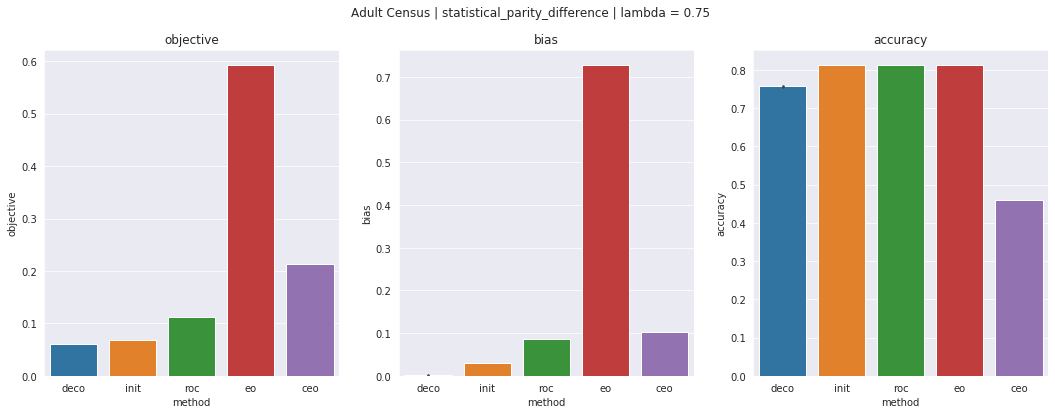

In [260]:
fig, axes = plt.subplots(ncols=3, nrows=1,figsize=(18,6), sharex=True)

sns.barplot(data=all_data, x="method", y="objective", ax=axes[0])
axes[0].set_title(f"objective")


sns.barplot(data=all_data, x="method", y="bias",  ax=axes[1])
axes[1].set_title(f"bias")


sns.barplot(data=all_data, x="method", y="accuracy",  ax=axes[2])
axes[2].set_title(f"accuracy")

fig.suptitle(f"Adult Census | {metric} | lambda = {1-C}")